# Importing Libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# Generating Dataset

In [2]:
from sklearn.datasets import make_gaussian_quantiles
X, Y = make_gaussian_quantiles(n_samples=50, n_features=2, n_classes=2,random_state=1)
Y = Y*2-1

In [3]:
X.shape

(50, 2)

In [4]:
print(X)

[[-0.74715829  1.6924546 ]
 [-0.17242821 -0.87785842]
 [ 1.13162939  1.51981682]
 [-0.22232814 -0.20075807]
 [ 0.30017032 -0.35224985]
 [-1.44411381 -0.50446586]
 [-0.12289023 -0.93576943]
 [ 2.18557541 -1.39649634]
 [ 1.62434536 -0.61175641]
 [-0.62000084  0.69803203]
 [ 0.42349435  0.07734007]
 [ 1.46210794 -2.06014071]
 [-0.37528495 -0.63873041]
 [-0.19183555 -0.88762896]
 [ 0.16003707  0.87616892]
 [ 0.18656139  0.41005165]
 [ 0.3190391  -0.24937038]
 [ 0.48851815 -0.07557171]
 [-0.26788808  0.53035547]
 [ 0.90159072  0.50249434]
 [ 1.65980218  0.74204416]
 [ 0.05080775 -0.63699565]
 [-0.75439794  1.25286816]
 [ 0.90085595 -0.68372786]
 [ 1.19891788  0.18515642]
 [-1.10061918  1.14472371]
 [-0.67066229  0.37756379]
 [ 0.28558733  0.88514116]
 [ 0.19091548  2.10025514]
 [-0.20889423  0.58662319]
 [ 0.19829972  0.11900865]
 [ 0.04221375  0.58281521]
 [-0.67124613 -0.0126646 ]
 [ 0.12015895  0.61720311]
 [ 0.86540763 -2.3015387 ]
 [ 1.13376944 -1.09989127]
 [ 0.31563495 -2.02220122]
 

In [5]:
print(Y)

[ 1 -1  1 -1 -1  1  1  1  1  1 -1  1 -1 -1 -1 -1 -1 -1 -1  1  1 -1  1  1
  1  1 -1 -1  1 -1 -1 -1 -1 -1  1  1  1  1 -1 -1  1  1  1 -1  1  1 -1 -1
 -1  1]


# Plot Function

In [6]:
def plot(X,Y,a_output=None):
    
    fig, ax = plt.subplots(figsize=(5, 5))
    s = np.ones(shape=X.shape[0])*50
    
    X_Neg = X[Y == -1]
    s_Neg = s[Y == -1] 
    
    X_Pos = X[Y == 1]
    s_Pos = s[Y == 1]
    
    ax.scatter(*X_Neg.T, s=s_Neg, marker='.', c='blue')
    ax.scatter(*X_Pos.T, s=s_Pos, marker='*', color='red')

    if a_output:
        p = 1
        x_Min = X[:, 0].min() - p
        Y_Min = X[:, 1].min() - p
        
        x_Max = X[:, 0].max() + p
        Y_Max = X[:, 1].max() + p
        
        plt_step = 0.01
        X_order = np.arange(x_Min, x_Max, plt_step)
        Y_order = np.arange(Y_Min, Y_Max, plt_step)
        
        X1, Y1 = np.meshgrid(X_order,Y_order)
        
        A = a_output.predict(np.c_[X1.ravel(), Y1.ravel()])
        A = A.reshape(X1.shape)
        
        if list(np.unique(A)) == [1]:
            fill_colors = ['y']
        else:
            fill_colors = ['b', 'y']
            
        ax.contourf(X1, Y1, A, colors=fill_colors, alpha=0.2)

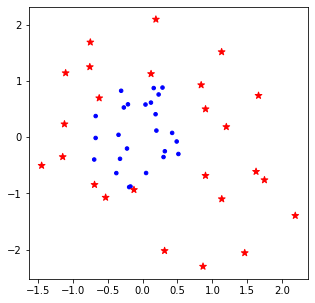

In [7]:
plot(X, Y)

# Train Test Split

In [8]:
# Train & Test Split (in 70:30 , i.e. 70% training, 30% testing)
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.3, random_state = 42)

In [9]:
X_train.shape

(35, 2)

In [10]:
Y_train.shape

(35,)

In [11]:
X_test.shape

(15, 2)

In [12]:
Y_test.shape

(15,)

# AdaBoost Classifier

In [13]:
from sklearn.tree import DecisionTreeClassifier

class AdaBoost_Classifier:
    
    def __init__(self):
        self.stmp_weights = None
        self.smpl_weights = None
        self.errors = None
        self.stmp = None
              
    def fit(self,X, y, iters: int):
        n = X.shape[0]

        self.stmp_weights = np.zeros(shape=iters)
        self.smpl_weights = np.zeros(shape=(iters, n))
        self.errors = np.zeros(shape=iters)
        self.stmp = np.zeros(shape=iters, dtype=object)
        self.smpl_weights[0] = np.ones(shape=n)/n

        for i in range(iters):
            
            # Weak Learner Fitting
            c_smpl_weights = self.smpl_weights[i]
            
            stump = DecisionTreeClassifier(max_depth=1, max_leaf_nodes=2)
            stump = stump.fit(X, y, sample_weight=c_smpl_weights)

            #Error and Stump weight Calculation from Weak Learner
            stump_pred = stump.predict(X)
            err = c_smpl_weights[(stump_pred != y)].sum()# / n
            stump_weight = np.log((1 - err) / err) / 2

            # Updating sample Weights
            new_smpl_weights = (
                c_smpl_weights * np.exp(-stump_weight * y * stump_pred)
            )

            new_smpl_weights /= new_smpl_weights.sum()

            if i+1 < iters:
                self.smpl_weights[i+1] = new_smpl_weights

            self.stmp[i] = stump
            self.stmp_weights[i] = stump_weight
            self.errors[i] = err
        return self

    def predict(self, X):
        stump_preds = np.array([stump.predict(X) for stump in self.stmp])
        return np.sign(np.dot(self.stmp_weights, stump_preds))

In [14]:
a_Classifier = AdaBoost_Classifier()
a_output = a_Classifier.fit(X_train, Y_train, iters=41)

In [15]:
print("Weights :",a_output.stmp_weights)

Weights : [0.39007928 0.39422868 0.41906595 0.36082904 0.40446354 0.42608406
 0.29502733 0.40588212 0.28547319 0.32675408 0.24465868 0.31889529
 0.28794198 0.35543219 0.31226384 0.23655888 0.28581807 0.22123992
 0.28618281 0.22145604 0.29404199 0.22607943 0.24872718 0.19852949
 0.24614956 0.19689582 0.23379233 0.18896051 0.23200118 0.18779595
 0.20298988 0.29378007 0.24559135 0.25844845 0.2046248  0.23960834
 0.19271676 0.22224344 0.21845386 0.28147653 0.37464879]


In [16]:
def accuracy(y_true, y_pred):
        accuracy = np.sum(y_true == y_pred) / len(y_true)
        return accuracy

# Plot of Train Dataset

Train error: 0.0%


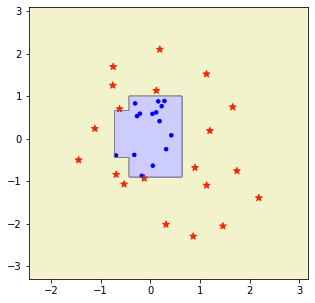

In [17]:
plot(X_train, Y_train, a_output)
trainError = (a_output.predict(X_train) != Y_train).mean()
print(f'Train error: {trainError:.1%}')

# Train Accuracy

In [18]:
yt_pred = a_output.predict(X_train)
acc = accuracy(Y_train, yt_pred)
print(f'Train Accuracy: {acc:.1%}')

Train Accuracy: 100.0%


# Test Accuracy

In [19]:
y_pred = a_output.predict(X_test)
acc = accuracy(Y_test, y_pred)
print(f'Test Accuracy: {acc:.1%}')

Test Accuracy: 100.0%
